## Tổng quan một mạng CNN cơ bản

![CNN](http://personal.ie.cuhk.edu.hk/~ccloy/project_target_code/images/fig3.png)

## MNIST dataset

Trong bài tập này, chúng ta sẽ sử dựng tập MNIST rất nổi tiếng vể  các chữ số viết tay từ 0->9. Tập dataset này bao gồm 60000 ảnh cho training và 10000 ảnh cho testing. Các bức ảnh này đều đã được căn giữa và chỉnh với kích thước cố định là 28x28.

Trong phần tiền xử lý, chúng ta sẽ cần chuẩn hóa các giá trị pixel của mỗi ảnh về khoảng [0,1], kiểu dữ liệu sẽ là float32

<!-- ![MNIST Dataset](http://neuralnetworksanddeeplearning.com/images/mnist_100_digits.png) -->

Chi tiết tại: http://yann.lecun.com/exdb/mnist/

# Some configs

- Chúng ta sẽ setup một số hyper-parameters cũng như một số giá trị cần dùng theo hướng dẫn nhé
- Ở đây, mình muốn các bạn sử dụng Cuda, hãy vào runtime, rồi change the runtime type sang GPU nhé 

In [1]:
# Trước hết, chúng ta import một số thư viện cần thiết đã
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
# Số classes trong tập MNIST
num_classes = 10

# Số epoch 
epochs = 5

# Các tham số cần thiết cho quá trình traning.
learning_rate = 0.001
batch_size = 100
display_step = 50

# Path lưu best model 
checkpoint = 'model.pth' # có thể để dạng *.pth

# device chúng ta dùng cuda
device = 'cuda' if torch.cuda.is_available() else 'cpu'
assert device == 'cuda' 

# Dataloader


In [3]:
# Transform image 
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)) 
    ])

# load dataset từ torchvision.datasets
train_dataset = datasets.MNIST('../data', train=True, download=True,transform=transform)
test_dataset = datasets.MNIST('../data', train=False,transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=batch_size,shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



# Model

- Trong bài này, chúng ta sẽ định nghĩa một class Net, nó sẽ có cấu trúc như hình ở đầu notebook
- Bạn hãy chỉnh các tham số cho phù hợp nhé :) 

In [4]:
class Net(nn.Module):
  def __init__(self):
    super(Net,self).__init__()
    self.dropout = nn.Dropout(0.4) #chưa dùng
    self.relu = nn.ReLU()
    self.conv1 = nn.Conv2d(1,32,3,1)
    self.maxpool1 = nn.MaxPool2d(2,2)
    self.conv2 = nn.Conv2d(32,64,3,1)
    self.maxpool2 = nn.MaxPool2d(2,2)
    self.conv3 = nn.Conv2d(64,64,3,1)
    self.maxpool3 = nn.MaxPool2d(2,2)
    self.fc1 = nn.Linear(64,128)
    self.fc2 = nn.Linear(128,128)
    self.fc3 = nn.Linear(128,num_classes)

  def forward(self,x):
    # n,1,28,28
    x = self.maxpool1(self.relu(self.conv1(x))) # n,10,26,26 -> n,10,13,13 
    x = self.maxpool2(self.relu(self.conv2(x))) # n,32,11,11 -> n,32,5,5
    x = self.maxpool3(self.relu(self.conv3(x))) # n,64,3,3 -> n,64,1,1
    x = self.dropout(x)
    x = x.view(-1, 64 * 1 * 1) # n,64
    x = self.fc1(x) # n, 128
    x = self.relu(x)
    x = self.dropout(x)
    x = self.fc2(x) # n, 128
    x = self.relu(x)
    x = self.dropout(x)
    x = self.fc3(x) # n, 10
    x = self.relu(x)
    return x

In [5]:
# call model, đừng quên set device nhé
model = Net().to(device)

# load lại pretrained model (nếu có)
try:
    model.load_state_dict(torch.load(checkpoint))
except:
  print("!!! Hãy train để có checkpoint file")

!!! Hãy train để có checkpoint file


In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
best_val_loss = 999

for epoch in range(1,epochs):
    # Quá trình training 
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad() # zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward() # backward()
        optimizer.step() # update
        if batch_idx % display_step == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    # Quá trình testing 
    model.eval()
    test_loss = 0
    correct = 0
    # set no grad cho quá trình testing
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            #  _, predicted = torch.max(output.data, 1) 
            output = F.log_softmax(output,dim=1) # log softmax dùng F, chú ý dim
            test_loss += criterion(output,target)
            pred = output.argmax(dim = 1,keepdim = True) # argmax để lấy predicted label, chú ý dim, và keepdim = True
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset) 
    if test_loss < best_val_loss:
      best_val_loss = test_loss
      torch.save(model.state_dict(), checkpoint) # lưu lại model 
      print("***********    TEST_ACC = {}%    ***********".format(correct))

Train Epoch: 1 [0/60000 (0%)]	Train Loss: 2.302049
Train Epoch: 1 [5000/60000 (8%)]	Train Loss: 2.023291
Train Epoch: 1 [10000/60000 (17%)]	Train Loss: 1.500931
Train Epoch: 1 [15000/60000 (25%)]	Train Loss: 1.418830
Train Epoch: 1 [20000/60000 (33%)]	Train Loss: 0.970940
Train Epoch: 1 [25000/60000 (42%)]	Train Loss: 1.115064
Train Epoch: 1 [30000/60000 (50%)]	Train Loss: 0.776182
Train Epoch: 1 [35000/60000 (58%)]	Train Loss: 0.612938
Train Epoch: 1 [40000/60000 (67%)]	Train Loss: 0.926239
Train Epoch: 1 [45000/60000 (75%)]	Train Loss: 0.750055
Train Epoch: 1 [50000/60000 (83%)]	Train Loss: 0.802398
Train Epoch: 1 [55000/60000 (92%)]	Train Loss: 0.942133
***********    TEST_ACC = 7704%    ***********
Train Epoch: 2 [0/60000 (0%)]	Train Loss: 0.659961
Train Epoch: 2 [5000/60000 (8%)]	Train Loss: 0.771011
Train Epoch: 2 [10000/60000 (17%)]	Train Loss: 0.453934
Train Epoch: 2 [15000/60000 (25%)]	Train Loss: 0.727798
Train Epoch: 2 [20000/60000 (33%)]	Train Loss: 0.673577
Train Epoch: 2 

In [7]:
# load lại model đã train
model.load_state_dict(torch.load(checkpoint))
# Set eval phase nhé bạn
model.eval()

Net(
  (dropout): Dropout(p=0.4, inplace=False)
  (relu): ReLU()
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)

In [8]:
item = iter(test_loader)

In [9]:
data,target = item.next() # lấy một batch ra

In [10]:
test_idx = random.choice(range(len(data))) # lấy index của một phần tử của một batch

In [11]:
data = data[test_idx]
target = target[test_idx]
assert data.shape == (1,28,28)

In [12]:
# thử predict 

def plot(data,model):
  data = torch.unsqueeze(data,dim=0).to(device) # unsqueeze data, đồng thời set device
  output = model(data) 
  output = F.log_softmax(output,dim=1) # log softmax, chú ý dim
  pred = output.argmax(dim = 1,keepdim = True) # argmax, chú ý keepdim 
  print("Predict Number : ", pred[0][0].detach().cpu().numpy()) 
  plt.imshow(data[0][0].detach().cpu().numpy(),cmap='gray') 
  plt.show()

Predict Number :  5


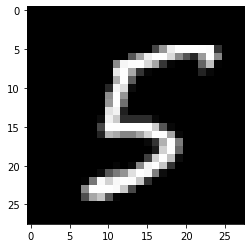

In [13]:
plot(data,model)